# CNN + MaxPool
Same as CNN_264 which achieved about 60% accuracy on all cell lines except H1.hESC. 

Here, run the same model on cell line H1.hESC only. 

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-26 18:21:13.235309


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=8 # 20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
NUM_CELL_LINES=15
EXCLUSIONS = {x for x in range(NUM_CELL_LINES) if x!=1}   # exclude all but H1.hESC
print('Exclusions:',EXCLUSIONS)

Python 3.9.16
sklearn 1.2.2
Exclusions: {0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop1_layer = Dropout(0.5)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop2_layer = Dropout(0.5)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool1_layer)
    cnn.add(drop1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool2_layer)
    cnn.add(drop2_layer)
    cnn.add(flat_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-26 18:21:41.974065
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4990, 64)          2112      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1246, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1246, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1239, 64)          32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 308, 64)          0         
 1D)                         

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-26 18:21:42.324259
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 3774
Num RCI: 3774
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 3774 sequences.
2023-03-26 18:21:50.665315

Training # 1 1
2023-03-26 18:21:50.665457
2023-03-26 18:21:50.665509
Discriminator ZERO -1
Train 1:0 1911:1120 63.05%
Computed class weights: {0: 1.353125, 1: 0.793040293040293}
Valid 1:0 488:255 65.68%
FIT
2023-03-26 18:21:51.689817


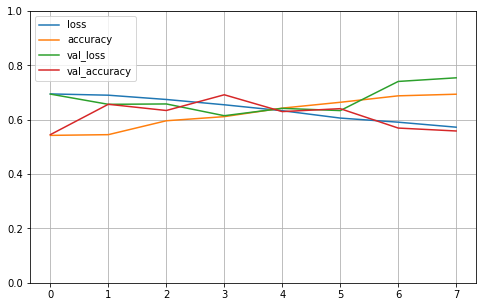


2023-03-26 18:22:13.796873

Testing # 1 1
2023-03-26 18:22:13.798307
2023-03-26 18:22:13.798636
PREDICT
2023-03-26 18:22:14.155304
Test 1:0 488:255 65.68%
Predict 1:0 324:419 43.61%
Test sizes (743, 4997) (743,)
Range of scores: 0.009092776 to 0.9861885
Score threshold 0.5
Confusion matrix
 [[173  82]
 [246 242]]
Normalized matrix
 [[0.23283984 0.11036339]
 [0.33109017 0.32570659]]


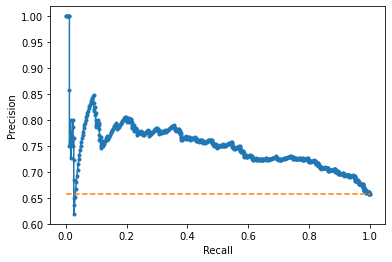

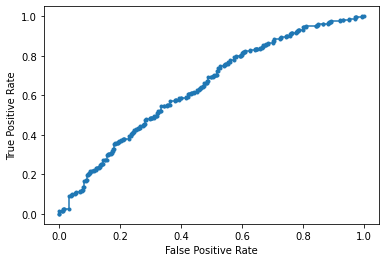

Accuracy: 55.85% Precision: 74.69% Recall: 49.59%
F1: 59.61% MCC: 0.1669
AUPRC: 74.89% AUROC: 64.08%
 accuracy [55.85464333781965]
 precision [74.69135802469135]
 recall [49.59016393442623]
 F1 [59.60591133004925]
 MCC [0.16690913945247304]
 AUPRC [74.8879962034364]
 AUROC [64.08309225329477]
2023-03-26 18:22:15.284303

Training # 1 2
2023-03-26 18:22:15.286882
2023-03-26 18:22:15.286962
Discriminator ZERO -1
Train 1:0 1914:1098 63.55%
Computed class weights: {0: 1.3715846994535519, 1: 0.786833855799373}
Valid 1:0 485:277 63.65%
FIT
2023-03-26 18:22:16.327924


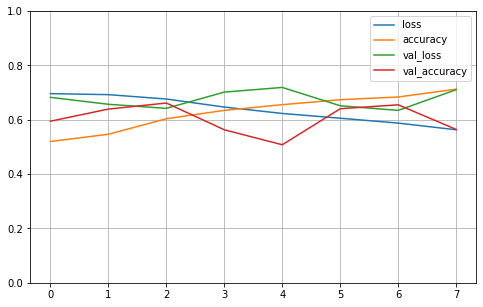


2023-03-26 18:22:28.788884

Testing # 1 2
2023-03-26 18:22:28.788995
2023-03-26 18:22:28.789032
PREDICT
2023-03-26 18:22:28.983866
Test 1:0 485:277 63.65%
Predict 1:0 325:437 42.65%
Test sizes (762, 4997) (762,)
Range of scores: 0.0245444 to 0.9675878
Score threshold 0.5
Confusion matrix
 [[191  86]
 [246 239]]
Normalized matrix
 [[0.25065617 0.11286089]
 [0.32283465 0.31364829]]


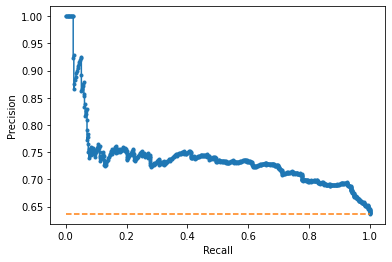

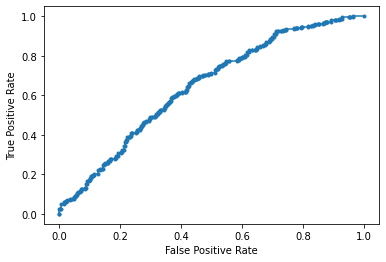

Accuracy: 56.43% Precision: 73.54% Recall: 49.28%
F1: 59.01% MCC: 0.1773
AUPRC: 73.77% AUROC: 64.55%
 accuracy [56.43044619422572]
 precision [73.53846153846155]
 recall [49.27835051546392]
 F1 [59.01234567901235]
 MCC [0.177316369100434]
 AUPRC [73.77176592853286]
 AUROC [64.55469127991365]
2023-03-26 18:22:29.868395

Training # 1 3
2023-03-26 18:22:29.868596
2023-03-26 18:22:29.868643
Discriminator ZERO -1
Train 1:0 1925:1106 63.51%
Computed class weights: {0: 1.370253164556962, 1: 0.7872727272727272}
Valid 1:0 474:269 63.80%
FIT
2023-03-26 18:22:30.913955


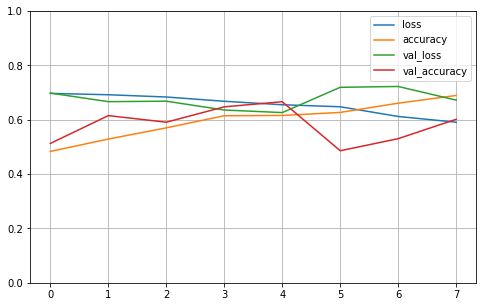


2023-03-26 18:22:43.455165

Testing # 1 3
2023-03-26 18:22:43.455271
2023-03-26 18:22:43.455306
PREDICT
2023-03-26 18:22:43.643485
Test 1:0 474:269 63.80%
Predict 1:0 422:321 56.80%
Test sizes (743, 4997) (743,)
Range of scores: 0.0736471 to 0.96773773
Score threshold 0.5
Confusion matrix
 [[147 122]
 [174 300]]
Normalized matrix
 [[0.19784657 0.16419919]
 [0.23418573 0.40376851]]


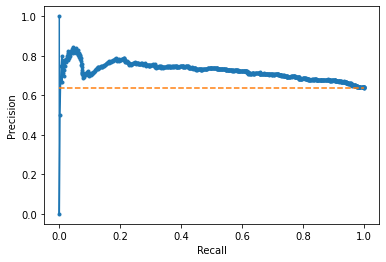

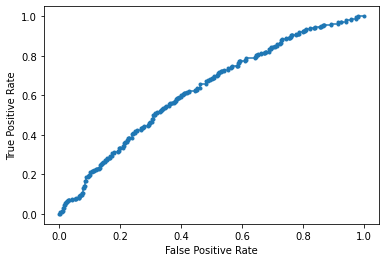

Accuracy: 60.16% Precision: 71.09% Recall: 63.29%
F1: 66.96% MCC: 0.1740
AUPRC: 72.31% AUROC: 62.82%
 accuracy [60.16150740242261]
 precision [71.09004739336493]
 recall [63.29113924050633]
 F1 [66.96428571428572]
 MCC [0.17403239216438016]
 AUPRC [72.30789790663368]
 AUROC [62.82371025677224]
2023-03-26 18:22:44.515766

Training # 1 4
2023-03-26 18:22:44.515955
2023-03-26 18:22:44.516000
Discriminator ZERO -1
Train 1:0 1939:1087 64.08%
Computed class weights: {0: 1.391904323827047, 1: 0.7802991232594121}
Valid 1:0 460:288 61.50%
FIT
2023-03-26 18:22:45.549367


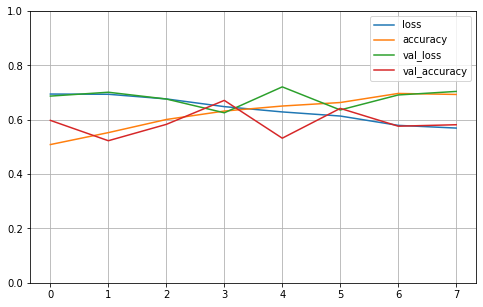


2023-03-26 18:23:07.272836

Testing # 1 4
2023-03-26 18:23:07.272942
2023-03-26 18:23:07.272980
PREDICT
2023-03-26 18:23:07.461579
Test 1:0 460:288 61.50%
Predict 1:0 323:425 43.18%
Test sizes (748, 4997) (748,)
Range of scores: 0.005212789 to 0.98222625
Score threshold 0.5
Confusion matrix
 [[200  88]
 [225 235]]
Normalized matrix
 [[0.26737968 0.11764706]
 [0.30080214 0.31417112]]


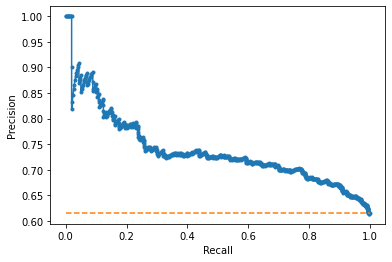

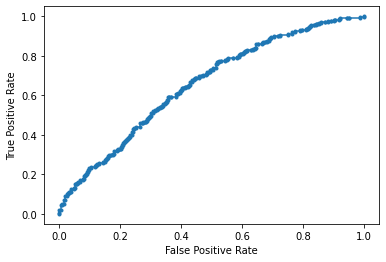

Accuracy: 58.16% Precision: 72.76% Recall: 51.09%
F1: 60.03% MCC: 0.2017
AUPRC: 73.82% AUROC: 65.64%
 accuracy [58.155080213903744]
 precision [72.75541795665634]
 recall [51.08695652173913]
 F1 [60.02554278416348]
 MCC [0.2016963402720172]
 AUPRC [73.81500333301148]
 AUROC [65.64085144927536]
2023-03-26 18:23:08.372154

Training # 1 5
2023-03-26 18:23:08.372342
2023-03-26 18:23:08.372389
Discriminator ZERO -1
Train 1:0 1907:1089 63.65%
Computed class weights: {0: 1.3755739210284665, 1: 0.7855270057682223}
Valid 1:0 492:286 63.24%
FIT
2023-03-26 18:23:09.397049


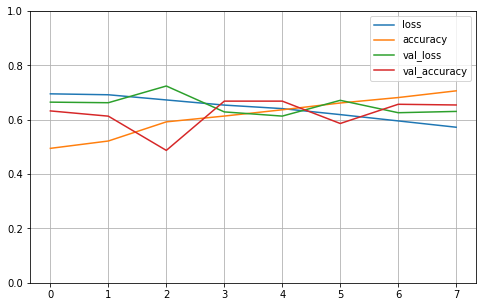


2023-03-26 18:23:22.213563

Testing # 1 5
2023-03-26 18:23:22.213991
2023-03-26 18:23:22.214027
PREDICT
2023-03-26 18:23:22.417775
Test 1:0 492:286 63.24%
Predict 1:0 577:201 74.16%
Test sizes (778, 4997) (778,)
Range of scores: 0.012898283 to 0.97342783
Score threshold 0.5
Confusion matrix
 [[109 177]
 [ 92 400]]
Normalized matrix
 [[0.14010283 0.22750643]
 [0.11825193 0.51413882]]


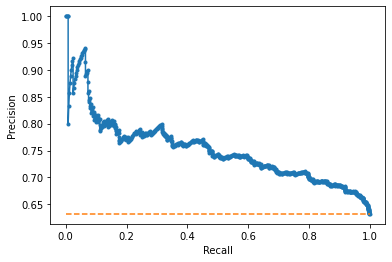

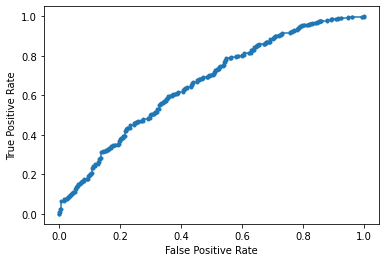

Accuracy: 65.42% Precision: 69.32% Recall: 81.30%
F1: 74.84% MCC: 0.2138
AUPRC: 75.18% AUROC: 65.99%
 accuracy [65.42416452442158]
 precision [69.32409012131716]
 recall [81.30081300813008]
 F1 [74.83629560336765]
 MCC [0.21382850561618486]
 AUPRC [75.1837798653356]
 AUROC [65.98868611063733]
2023-03-26 18:23:23.300677

Training # 2 1
2023-03-26 18:23:23.300910
2023-03-26 18:23:23.300960
Discriminator ZERO -1
Train 1:0 1912:1111 63.25%
Computed class weights: {0: 1.3604860486048604, 1: 0.7905334728033473}
Valid 1:0 487:264 64.85%
FIT
2023-03-26 18:23:24.327480


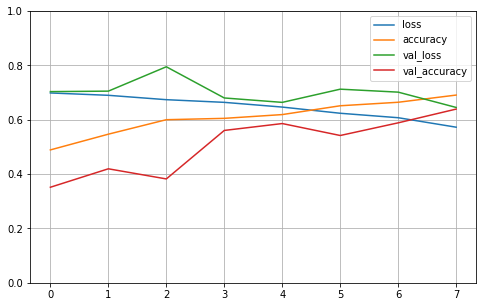


2023-03-26 18:23:36.627887

Testing # 2 1
2023-03-26 18:23:36.628291
2023-03-26 18:23:36.628322
PREDICT
2023-03-26 18:23:36.845707
Test 1:0 487:264 64.85%
Predict 1:0 468:283 62.32%
Test sizes (751, 4997) (751,)
Range of scores: 0.024497049 to 0.9765529
Score threshold 0.5
Confusion matrix
 [[138 126]
 [145 342]]
Normalized matrix
 [[0.18375499 0.1677763 ]
 [0.1930759  0.45539281]]


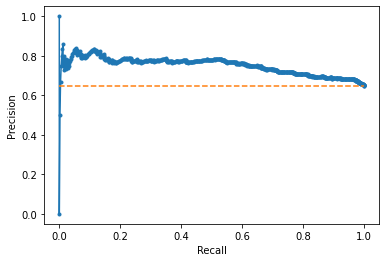

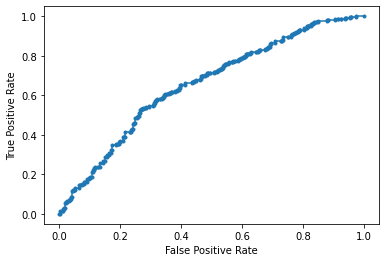

Accuracy: 63.91% Precision: 73.08% Recall: 70.23%
F1: 71.62% MCC: 0.2217
AUPRC: 75.06% AUROC: 65.61%
 accuracy [63.914780292942744]
 precision [73.07692307692307]
 recall [70.2258726899384]
 F1 [71.62303664921465]
 MCC [0.22166942437967435]
 AUPRC [75.06429060347348]
 AUROC [65.61274967332463]
2023-03-26 18:23:37.690987

Training # 2 2
2023-03-26 18:23:37.691174
2023-03-26 18:23:37.691220
Discriminator ZERO -1
Train 1:0 1922:1106 63.47%
Computed class weights: {0: 1.3688969258589512, 1: 0.7877211238293444}
Valid 1:0 477:269 63.94%
FIT
2023-03-26 18:23:38.733585


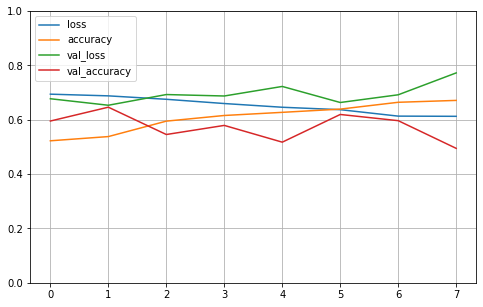


2023-03-26 18:24:00.447140

Testing # 2 2
2023-03-26 18:24:00.447230
2023-03-26 18:24:00.447256
PREDICT
2023-03-26 18:24:00.627729
Test 1:0 477:269 63.94%
Predict 1:0 288:458 38.61%
Test sizes (746, 4997) (746,)
Range of scores: 0.038294926 to 0.95097697
Score threshold 0.5
Confusion matrix
 [[175  94]
 [283 194]]
Normalized matrix
 [[0.23458445 0.12600536]
 [0.37935657 0.26005362]]


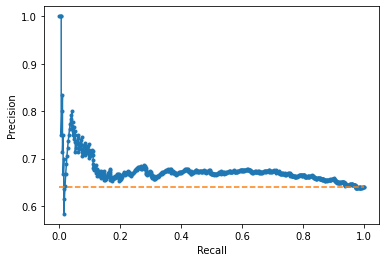

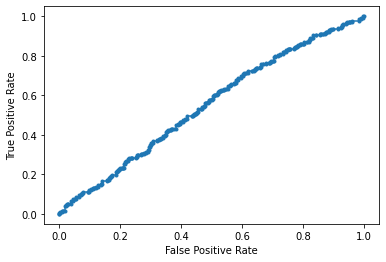

Accuracy: 49.46% Precision: 67.36% Recall: 40.67%
F1: 50.72% MCC: 0.0565
AUPRC: 67.46% AUROC: 55.16%
 accuracy [49.46380697050938]
 precision [67.36111111111111]
 recall [40.670859538784065]
 F1 [50.71895424836601]
 MCC [0.056481319657175066]
 AUPRC [67.46127141090443]
 AUROC [55.160428015867446]
2023-03-26 18:24:01.475798

Training # 2 3
2023-03-26 18:24:01.475967
2023-03-26 18:24:01.476013
Discriminator ZERO -1
Train 1:0 1915:1096 63.60%
Computed class weights: {0: 1.373631386861314, 1: 0.7861618798955614}
Valid 1:0 484:279 63.43%
FIT
2023-03-26 18:24:02.521439


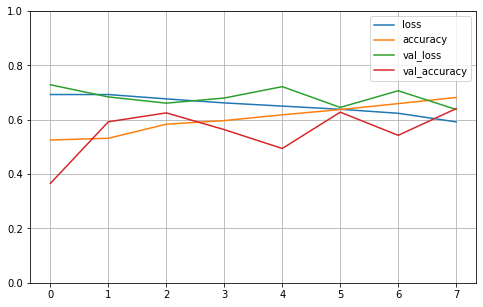


2023-03-26 18:24:15.983632

Testing # 2 3
2023-03-26 18:24:15.983725
2023-03-26 18:24:15.983767
PREDICT
2023-03-26 18:24:16.175251
Test 1:0 484:279 63.43%
Predict 1:0 488:275 63.96%
Test sizes (763, 4997) (763,)
Range of scores: 0.022520918 to 0.9656167
Score threshold 0.5
Confusion matrix
 [[140 139]
 [135 349]]
Normalized matrix
 [[0.18348624 0.18217562]
 [0.17693316 0.45740498]]


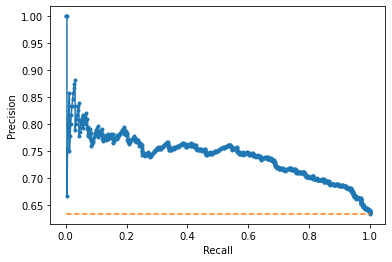

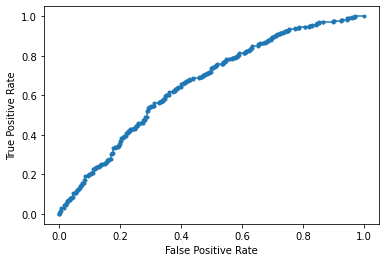

Accuracy: 64.09% Precision: 71.52% Recall: 72.11%
F1: 71.81% MCC: 0.2236
AUPRC: 74.26% AUROC: 66.03%
 accuracy [64.08912188728702]
 precision [71.51639344262296]
 recall [72.10743801652893]
 F1 [71.81069958847736]
 MCC [0.22355959145199678]
 AUPRC [74.26246428259353]
 AUROC [66.03424272045973]
2023-03-26 18:24:17.017404

Training # 2 4
2023-03-26 18:24:17.017571
2023-03-26 18:24:17.017618
Discriminator ZERO -1
Train 1:0 1935:1093 63.90%
Computed class weights: {0: 1.385178408051235, 1: 0.7824289405684755}
Valid 1:0 464:282 62.20%
FIT
2023-03-26 18:24:18.075812


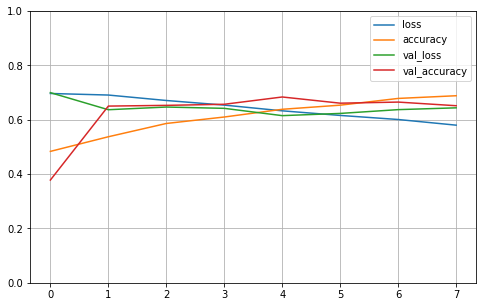


2023-03-26 18:24:39.831835

Testing # 2 4
2023-03-26 18:24:39.831933
2023-03-26 18:24:39.831970
PREDICT
2023-03-26 18:24:40.013156
Test 1:0 464:282 62.20%
Predict 1:0 492:254 65.95%
Test sizes (746, 4997) (746,)
Range of scores: 0.04732717 to 0.97246695
Score threshold 0.5
Confusion matrix
 [[138 144]
 [116 348]]
Normalized matrix
 [[0.1849866  0.19302949]
 [0.15549598 0.46648794]]


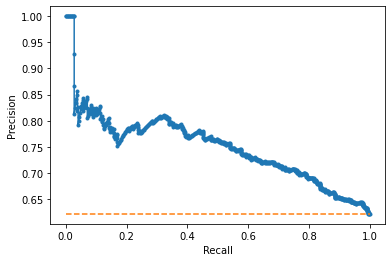

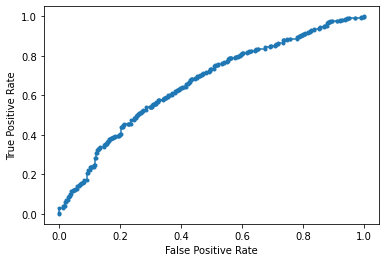

Accuracy: 65.15% Precision: 70.73% Recall: 75.00%
F1: 72.80% MCC: 0.2449
AUPRC: 74.99% AUROC: 66.33%
 accuracy [65.14745308310992]
 precision [70.73170731707317]
 recall [75.0]
 F1 [72.80334728033473]
 MCC [0.24492820474667545]
 AUPRC [74.98813535791805]
 AUROC [66.33269136708242]
2023-03-26 18:24:40.848542

Training # 2 5
2023-03-26 18:24:40.848732
2023-03-26 18:24:40.850820
Discriminator ZERO -1
Train 1:0 1912:1094 63.61%
Computed class weights: {0: 1.3738574040219378, 1: 0.7860878661087866}
Valid 1:0 487:281 63.41%
FIT
2023-03-26 18:24:41.906054


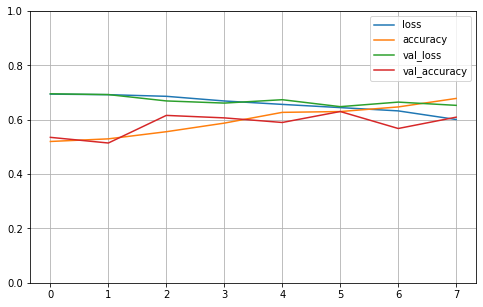


2023-03-26 18:24:54.237442

Testing # 2 5
2023-03-26 18:24:54.237748
2023-03-26 18:24:54.237799
PREDICT
2023-03-26 18:24:54.425951
Test 1:0 487:281 63.41%
Predict 1:0 493:275 64.19%
Test sizes (768, 4997) (768,)
Range of scores: 0.047484457 to 0.9563654
Score threshold 0.5
Confusion matrix
 [[128 153]
 [147 340]]
Normalized matrix
 [[0.16666667 0.19921875]
 [0.19140625 0.44270833]]


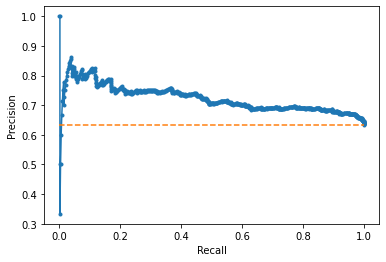

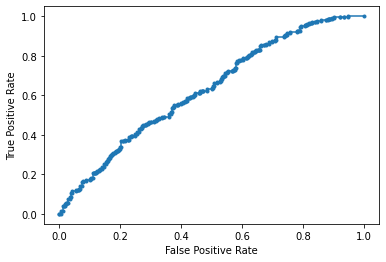

Accuracy: 60.94% Precision: 68.97% Recall: 69.82%
F1: 69.39% MCC: 0.1544
AUPRC: 72.32% AUROC: 62.94%
 accuracy [60.9375]
 precision [68.96551724137932]
 recall [69.81519507186859]
 F1 [69.38775510204083]
 MCC [0.15438715843407647]
 AUPRC [72.32344692700518]
 AUROC [62.939633313116104]
2023-03-26 18:24:55.062779


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 59.96% std 5.09
 precision mean 71.31% std 2.29
 recall mean 62.24% std 13.59
 F1 mean 65.68% std 7.89
 MCC mean 0.18% std 0.05
 AUPRC mean 73.41% std 2.34
 AUROC mean 63.92% std 3.33
 accuracy [[55.85464333781965], [56.43044619422572], [60.16150740242261], [58.155080213903744], [65.42416452442158], [63.914780292942744], [49.46380697050938], [64.08912188728702], [65.14745308310992], [60.9375]]
 precision [[74.69135802469135], [73.53846153846155], [71.09004739336493], [72.75541795665634], [69.32409012131716], [73.07692307692307], [67.36111111111111], [71.51639344262296], [70.73170731707317], [68.96551724137932]]
 recall [[49.59016393442623], [49.27835051546392], [63.29113924050633], [51.08695652173913], [81.30081300813008], [70.2258726899384], [40.670859538784065], [72.10743801652893], [75.0], [69.81519507186859]]
 F1 [[59.60591133004925], [59.01234567901235], [66.96428571428572], [60.02554278416348], [74.83629560336765], [71.62303664921465], [50.71895424836601], [71.8106